In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# we import the train and test datasets and we delete the answer id because it will not add relevant 
# information to the model
train  = pd.read_csv('train.csv', index_col = 0).drop('id', axis = 1)
# we replace some values to facilitate the use of the dataset
train.columns = train.columns.str.replace(' ', '_')
train.columns = train.columns.str.replace('-', '_')
train.columns = train.columns.str.lower()

test = pd.read_csv('test.csv', index_col = 0).drop('id', axis = 1)
test.columns = test.columns.str.replace(' ', '_')
test.columns = test.columns.str.replace('-', '_')
test.columns = test.columns.str.lower()

# we merge the two datasets together, in case some adjustments are needed.
df = pd.concat([train, test])

# 1. Business case
The dataset we are provided contains an airline passenger satisfaction survey. The aim of this project is to understand which factors are highly correlated to a satisfied (or dissatisfied) passenger, and to build an algorithm capable of predicting passenger satisfaction.

The following 22 features represents the answers to the questions asked in the survey:

- **Gender**: Gender of the passengers (Female, Male)
- **Customer Type**: The customer type (Loyal customer, disloyal customer)
- **Age**: The actual age of the passengers
- **Type of Travel**: Purpose of the flight of the passengers (Personal Travel, Business Travel)
- **Class**: Travel class in the plane of the passengers (Business, Eco, Eco Plus)
- **Flight distance**: The flight distance of this journey
- **Inflight wifi service**: Satisfaction level of the inflight wifi service (0:Not Applicable;1-5)
- **Departure/Arrival time convenient**: Satisfaction level of Departure/Arrival time convenient
- **Ease of Online booking**: Satisfaction level of online booking
- **Gate location**: Satisfaction level of Gate location
- **Food and drink**: Satisfaction level of Food and drink
- **Online boarding**: Satisfaction level of online boarding
- **Seat comfort:** Satisfaction level of Seat comfort
- **Inflight entertainment**: Satisfaction level of inflight entertainment
- **On-board service**: Satisfaction level of On-board service
- **Leg room service**: Satisfaction level of Leg room service
- **Baggage handling**: Satisfaction level of baggage handling
- **Check-in service**: Satisfaction level of Check-in service
- **Inflight service**: Satisfaction level of inflight service
- **Cleanliness**: Satisfaction level of Cleanliness
- **Departure Delay in Minutes**: Minutes delayed when departure
- **Arrival Delay in Minutes**: Minutes delayed when Arrival

Finally, the **Satisfaction** feature is the target of our model and represents whether the client was satisfied, neutral or dissatisfied of the experience with the airline company.


# 2. Exploratory Data Analysis (EDA)
The first thing we want to do is to get some insight about the data we have.<br>
We need to check if there are some outliers, verify the presence of null values, and inspect the type of features we have and how to manage them. Moreover, we must check whether the class is balanced and then decide the metric to compare the models, as well as controlling the necessity of each feature and multicollinearity.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129880 entries, 0 to 25975
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   gender                             129880 non-null  object 
 1   customer_type                      129880 non-null  object 
 2   age                                129880 non-null  int64  
 3   type_of_travel                     129880 non-null  object 
 4   class                              129880 non-null  object 
 5   flight_distance                    129880 non-null  int64  
 6   inflight_wifi_service              129880 non-null  int64  
 7   departure/arrival_time_convenient  129880 non-null  int64  
 8   ease_of_online_booking             129880 non-null  int64  
 9   gate_location                      129880 non-null  int64  
 10  food_and_drink                     129880 non-null  int64  
 11  online_boarding                    12988

In [4]:
df['arrival_delay_in_minutes'].isna().sum()

393

In [5]:
df['departure_delay_in_minutes'].min()

0

Since the dataset is made up of survey responses, most of the values are on a scale from 0 to 5, but there are also some continuous and categorical values we need to adress. More specifically, **arrival delary** and **departure delay** share the same metric (minutes), but use two different data types. There are also some missing values for **arrival delay**, which might be related to an arrival delay of 0 minutes. To verify this, we plot the distribution of departure and arrival delay:

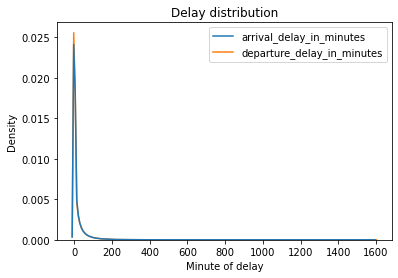

,arrival_delay_in_minutes,departure_delay_in_minutes
count,129487.000000,129880.000000
mean,15.091129,14.713713
std,38.465650,38.071126
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,13.000000,12.000000
max,1584.000000,1592.000000


,arrival_delay_in_minutes,departure_delay_in_minutes
0,0.0,0


In [6]:
sns.kdeplot(data = df[['arrival_delay_in_minutes', 'departure_delay_in_minutes']])
plt.title('Delay distribution')
plt.xlabel('Minute of delay')
plt.show()

display((df[['arrival_delay_in_minutes', 'departure_delay_in_minutes']].describe()))
display(df[['arrival_delay_in_minutes', 'departure_delay_in_minutes']].mode())

There are some cases where the delay is very high, but generally it is limited to just a couple of minutes. Indeed, the mode shows that the most common value is 0, which means that airplanes usually arrive on time. This is also strongly depicted by the 25% and 50% quartiles.<br>
However, this graph mainly shows that **departure delay** and **arrival delay** have almost the same distribution, with smalle discrepancies. Also, if there is any delay on departure, that delay would weigh on the arrival, so we expect the values to be very similar.

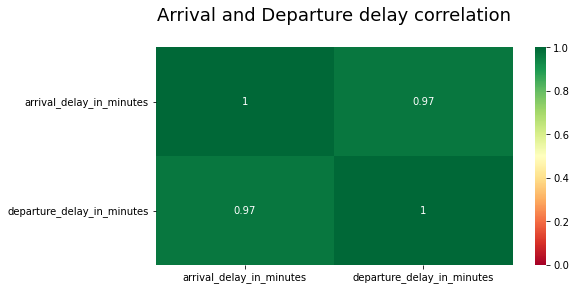

In [7]:
plt.figure(figsize = (8,4))
# plots the correlation of arrival_delay_in_minutes and departure_delay_in_minutes using the heatmap, 
# with the minimum set to 0 to. better show the relationship

sns.heatmap(df[['arrival_delay_in_minutes', 'departure_delay_in_minutes']].corr(),
           annot = True, cmap = 'RdYlGn', vmin=0, vmax=1)

plt.title('Arrival and Departure delay correlation\n', size = 18)

plt.show()

After this evaluation, we decide to combine the **arrival delay** and **departure delay** features, and create a new one - **delay in minutes** - which contains the values of the arrival delay and replaces the null values with those of departure delay.

In [8]:
# the new column has the arrival_delay_in_minutes and fills the NaN with those of departure_delay_in_minute

df['delay_in_minutes'] = df['arrival_delay_in_minutes'].fillna(df['departure_delay_in_minutes'])\
        .astype('int64')

# drop the old columns
df = df.drop(['arrival_delay_in_minutes', 'departure_delay_in_minutes'], axis = 1)

Now we check the categorical variables:

In [9]:
df['gender'].value_counts()

Female    65899
Male      63981
Name: gender, dtype: int64

In [10]:
df['customer_type'].value_counts()

Loyal Customer       106100
disloyal Customer     23780
Name: customer_type, dtype: int64

In [11]:
df['type_of_travel'].value_counts()

Business travel    89693
Personal Travel    40187
Name: type_of_travel, dtype: int64

In [12]:
df['class'].value_counts()

Business    62160
Eco         58309
Eco Plus     9411
Name: class, dtype: int64

Except for **class**, each other variable can be handled with a simple True/False statement. In other words, we just need to replace the values into 0 and 1. For **class** the situation is different. On one hand, it might make sense to replace Eco with 0, Eco Plus with 1, and Business with 2, to simbolize the levels of comfort, but on the other, we risk that the model interprets the map wrongly (For example, Business = 2 x Eco Plus).<br>
Therefore, we decide to create different columns for each class and use True/False statements.

The last check we do before replacing values, it on the **satisfaction** (target) distribution:

In [13]:
print('CLASS DISTRIBUTION');print()
print(df['satisfaction'].value_counts());print()
print(df['satisfaction'].value_counts(normalize = True))

CLASS DISTRIBUTION

neutral or dissatisfied    73452
satisfied                  56428
Name: satisfaction, dtype: int64

neutral or dissatisfied    0.565537
satisfied                  0.434463
Name: satisfaction, dtype: float64


There is a slight predominance of the *neutral or dissatisfied* label, but it does not create a big impact and a *stratified* strategy should be enough to avoid the issue.<br>
As a matter of fact, considering the label distribution, we use **accuracy** as a metric for addressing the quality of the models.

In [14]:
df['gender'] = df['gender'].replace({'Female':0, 'Male':1})
df['customer_type'] = df['customer_type'].replace({'Loyal Customer':1, 'disloyal Customer':0})
df['type_of_travel'] = df['type_of_travel'].replace({'Business travel':1, 'Personal Travel':0})
df = pd.get_dummies(df, columns = ['class'])

df['satisfaction'] = df['satisfaction'].replace({'satisfied':1, 'neutral or dissatisfied':0})

df = df[['gender', 'customer_type', 'age', 'type_of_travel', 'flight_distance',
       'inflight_wifi_service', 'departure/arrival_time_convenient',
       'ease_of_online_booking', 'gate_location', 'food_and_drink',
       'online_boarding', 'seat_comfort', 'inflight_entertainment',
       'on_board_service', 'leg_room_service', 'baggage_handling',
       'checkin_service', 'inflight_service', 'cleanliness', 'delay_in_minutes', 
         'class_Business', 'class_Eco', 'class_Eco Plus','satisfaction']]

X = df.iloc[:,:-1]
y = df.iloc[:,-1]

## 2.1 Outlier detection
The next step involves the detection of outliers. In general, outliers are anomalies that differ from the normal cases; if we created a model containing such data, the result would be an algorithm that makes decision using biased information.<br>

Anyway, we can't simply remove the outliers. We need to compare the model we would create without these values, with one that contains each instance. To do this, we use the GaussianNB because it is very fast in training and  making predictions.

In [15]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB

# we divide in train and test dataset the whole dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, 
                                                    random_state=42, stratify=y)

model = GaussianNB()

cv = StratifiedKFold(shuffle=True, random_state=42)
# we use GridSearchCV so that we create the best possible model for the data we are using
search_space={'var_smoothing': np.logspace(0,-9, num=100)}
clf = GridSearchCV(model, param_grid = search_space, 
                   cv = cv, scoring = 'accuracy').fit(X_train, y_train)


# this is the result we use as comparison
predicts_base = clf.best_estimator_.predict(X_test)

np.around(accuracy_score(y_test, predicts_base), 5)

0.85479

Since most of the values go from 0 to 5 (and some other are categorical variable), there are only a couple of features that could contain outliers. That is, **Age**, **Flight Distance** and **Delay in minutes**. We already know that **Delay in minutes** contains many outliers, so we only plot a chart for the remaining two

Text(0.5, 1.0, 'Flight Distance data distribution\n')

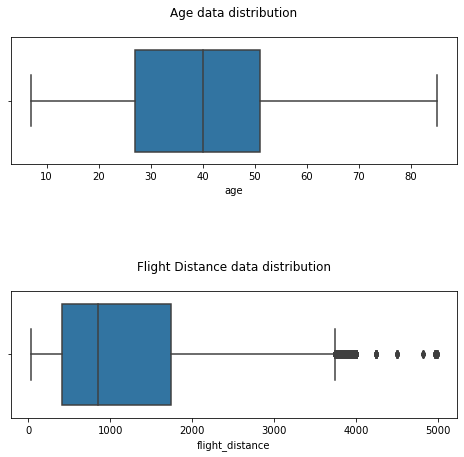

In [16]:
fig, ax = plt.subplots(2,1, figsize = (8,7))
plt.subplots_adjust(hspace = 1)

sns.boxplot(data = df, x = 'age', ax = ax[0])
ax[0].set_title('Age data distribution\n')
sns.boxplot(data = df, x = 'flight_distance', ax = ax[1])
ax[1].set_title('Flight Distance data distribution\n')

Considering the distributions, we try to detect the outliers of **Flight distance** and **Delay in minutes**.<br>
We use two methods: the *Z-SCORE* and the *IQR* (InterQuantile Range).
### 2.1.1. Z-SCORE
The z-score indicates which standard deviation a values falls within. If it exceeds the 3rd standard deviation, it is considered an outlier.

In [17]:
# create a function that detects the outliers out of some data given a threshold for the z-score
def z_model_detect_outlier(data, threshold):
    
    # create an empty list to contain the outliers
    outliers = []
    # compute mean
    mean = np.mean(data)
    # compute standard deviation
    std = np.std(data)
    
    # compute the z-score for each instance
    for i in data:
        z_score = (i - mean)/std
        
        # if the z-score is higher than the threshold, it is an outlier
        if np.abs(z_score) > threshold:
            outliers.append(i)
            
    return outliers


# create a function that creates a model with the outliers
def z_model_outlier_model (df, columns):
    
    # set the threshold. Usually 3 std is the standard
    thresholds = [2, 2.5, 3]
    # create an empty list to store the accuracy for each threshold
    results = []

    
    for threshold in thresholds:
               
        
        # if there are more columns, call the function for each column and we get rid of each outlier
        if type(columns) == list:   
            for column in columns:
                outliers = z_model_detect_outlier(df[column], threshold)
                # if there are no outliers, go to the next threshold (or finish loop)
                if not outliers:
                    continue
                min_ = min(outliers)
                t = df[df[column] < min_]
                
         
        # if just a column is indicated call the function for just that column
        elif type(columns) == str:
            column = columns
            outliers = z_model_detect_outlier(df[column], threshold)
            # if there are no outliers, go to the next threshold (or finish loop)
            if not outliers:
                continue
            min_ = min(outliers)
            t = df[df[column] < min_]
            
        
        # set the X and y of the new dataset without outliers
        t_X = t.iloc[:,:-1]
        t_y = t.iloc[:,-1]

        # set the search space to get the best model
        search_space={'var_smoothing': np.logspace(0,-9, num=100)}
        model = GaussianNB()

        cv = StratifiedKFold(shuffle=True, random_state=42)
        # fit the model on the X and y without outliers
        clf = GridSearchCV(model, param_grid = search_space, 
                   cv = cv, scoring = 'accuracy').fit(t_X, t_y)

        # predict on the test set (with outliers)
        predicts = clf.best_estimator_.predict(X_test)
        # add the result to the list
        results.append([np.around(accuracy_score(y_test, predicts), 5), threshold])
    
    
    # print the best accuracy and the threshold connected to it
    print('Accuracy without Z-MODEL outliers for {}: {} ; with a threshold of: {}'\
          .format(columns, max(results)[0], max(results)[1]))
    
    
# -----------------------------------------


# create a dataframe with just the train part of the dataset. We do this because the test set 
# (or any future data we will get) might have some outliers
t = pd.concat([X_train, y_train], axis = 1)

z_model_outlier_model(t, 'delay_in_minutes')
z_model_outlier_model(t, 'flight_distance')
z_model_outlier_model(t, ['delay_in_minutes', 'flight_distance'])
print()
print('Accuracy including outliers: ', np.around(accuracy_score(y_test, predicts_base), 5))


Accuracy without Z-MODEL outliers for delay_in_minutes: 0.8531 ; with a threshold of: 3
Accuracy without Z-MODEL outliers for flight_distance: 0.85448 ; with a threshold of: 3
Accuracy without Z-MODEL outliers for ['delay_in_minutes', 'flight_distance']: 0.85448 ; with a threshold of: 3

Accuracy including outliers:  0.85479


### 2.1.2. IQR
This method is based on percentiles. We compute 25% and 75% of some data, and we use them to set a limit that indicates what instances must be removed. In other words, all values that fall outside the limit will be discarted.

In [18]:
def IQR_outlier_model(df, columns):
    
    # if there are more columns, get rif of the outliers for each column 
    if type(columns) == list:  
        
        
        for column in columns:
            # compute the 25% and 50% percentile
            quantile1, quantile3 = np.percentile(df[column], [25, 75])
            # compute the IQR value
            iqr_value = quantile3 - quantile1
            # compute the lower and higher bonds of the IQR range 
            lower_bond = quantile1 - (1.5 * iqr_value)
            higher_bond = quantile3 + (1.5 * iqr_value)
            # remove everything that is not withing this limit
            t = df[(df[column] > lower_bond) & (df[column] < higher_bond)]
            
            
    # if there is one column, get rid of its outliers
    elif type(columns) == str:
        column = columns
        # compute the 25% and 50% percentile
        quantile1, quantile3 = np.percentile(df[column], [25, 75])
        # compute the IQR value
        iqr_value = quantile3 - quantile1
        # compute the lower and higher bonds of the IQR range 
        lower_bond = quantile1 - (1.5 * iqr_value)
        higher_bond = quantile3 + (1.5 * iqr_value)
        # remove everything that is not withing this limit
        t = df[(df[column] > lower_bond) & (df[column] < higher_bond)]

        
    # set the X and y of the new dataset without outliers
    t_X = t.iloc[:,:-1]
    t_y = t.iloc[:,-1]

    # set the search space to get the best model
    search_space={'var_smoothing': np.logspace(0,-9, num=100)}
    model = GaussianNB()

    cv = StratifiedKFold(shuffle=True, random_state=42)
    # fit the model on the X and y without outliers
    clf = GridSearchCV(model, param_grid = search_space, 
                   cv = cv, scoring = 'accuracy').fit(t_X, t_y)

    # predict on the test set (with outliers)
    predicts = clf.best_estimator_.predict(X_test)
    
    # print the accuracy
    print('Accuracy without IQR outliers for {}: {}'\
          .format(columns, np.around(accuracy_score(y_test, predicts), 5)))

    
# -----------------------------------------


# create a dataframe with just the train part of the dataset. We do this because the test set 
# (or any future data we will get) might have some outliers
t = pd.concat([X_train, y_train], axis = 1)   
IQR_outlier_model(t, 'delay_in_minutes')
IQR_outlier_model(t, 'flight_distance')
IQR_outlier_model(t, ['delay_in_minutes', 'flight_distance'])
print()
print('Accuracy including outliers: ', np.around(accuracy_score(y_test, predicts_base), 5))

Accuracy without IQR outliers for delay_in_minutes: 0.83898
Accuracy without IQR outliers for flight_distance: 0.85407
Accuracy without IQR outliers for ['delay_in_minutes', 'flight_distance']: 0.85407

Accuracy including outliers:  0.85479


### 2.1.3. Decision
After finding the outliers, we learn that the best choice is to keep the original dataframe. This could be because such data helps the model figure out what to do when it encounters new outliers, possibly because, while outliers are rare, they are so much different from the normal values that the algorithm wouldn't know how to handle them.

# 3. Feature selection
Are all features important or can we just take a some o them and discard others? If we can choose just some of them, the model will be faster and more efficient.<br>
To check this, we use some different methods. We start by plotting a **correlation matrix**.

<AxesSubplot:>

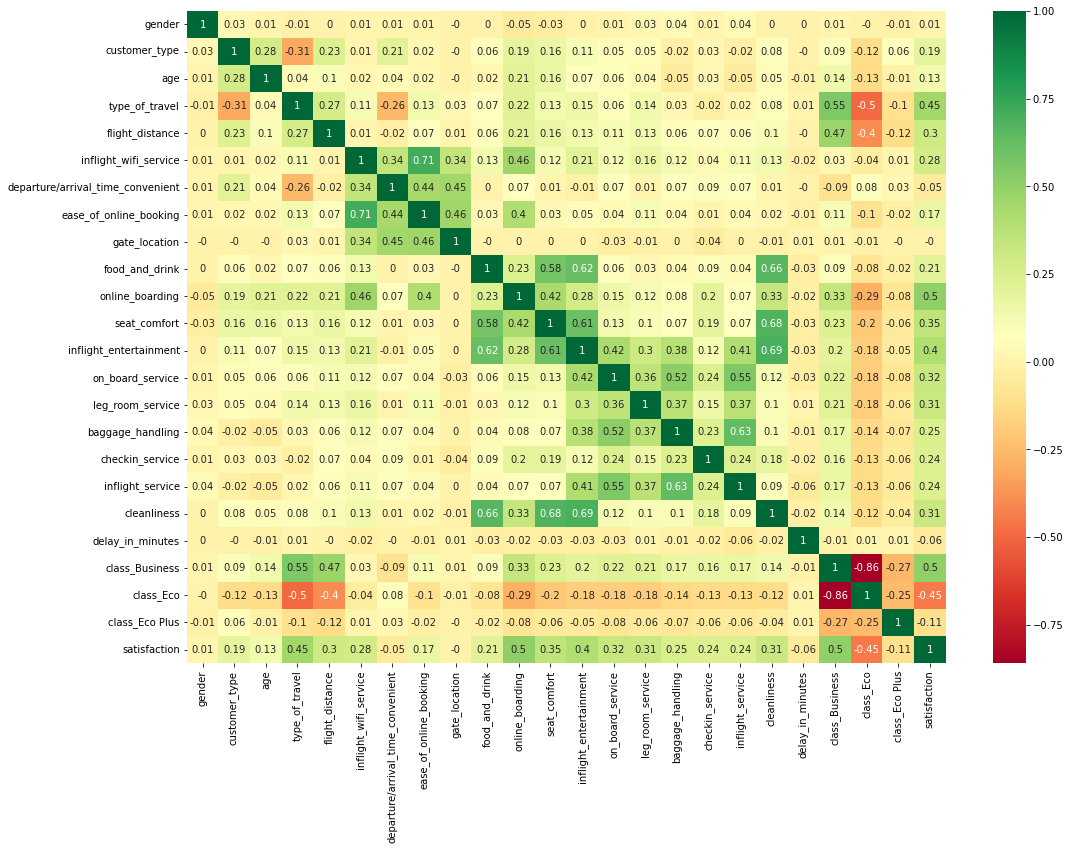

In [19]:
corrmap = df.corr()
plt.figure(figsize = (17,12))

sns.heatmap(np.around(corrmap,2), annot = True, cmap = 'RdYlGn')

From this correlation matrix we can see that there are not some features that have a strong correlation with our target (**satisfaction**), but there are a couple that seem to be a little more important:
- **type of travel**
- **online boarding**
- **class business**
- **class eco**
- **inflight entertainment**

<br>

The next method is the *chi-squared test*, which can be used in feature selection to find variables that are highly related to the target. The higher the value, the greater the dependence to the target.
The Sklearn library provides the function *SelectKBest* which finds the best features given a metric, which in our case is *chi-squared*.

In [20]:
from sklearn.feature_selection import SelectKBest, chi2

select_k_best_classifier = SelectKBest(chi2, k=5).fit(X,y)
mask = select_k_best_classifier.get_support()
new_features = X.columns[mask]

X_new = pd.DataFrame(select_k_best_classifier.fit_transform(X, y),  columns = new_features)

X_new.head()

,flight_distance,online_boarding,delay_in_minutes,class_Business,class_Eco
0,460,3,18,0,0
1,235,3,6,1,0
2,1142,5,0,1,0
3,562,2,9,1,0
4,214,5,0,1,0


The results are slightly different from those we got from the correlation matrix. **Class Eco**, **Class Business** and **Online boarding** are in common, but **flight distance** and **delay in minutes** are note. The interesting thing is that the first is someway among the most important features, but the latter is not.<br>
To get a better understanding of the situation, let's use the *mutal information* method, which shows how much information a feature provides. It is strongly related to the s+decision trees+, which uses as its first feature the one that allows the model to make the best subdivision between classes. 

Text(0, 0.5, '')

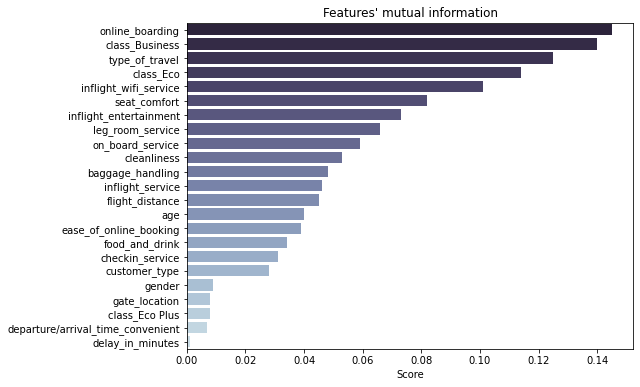

In [21]:
from sklearn.feature_selection import mutual_info_classif

mutual_info = pd.DataFrame(np.around( mutual_info_classif(X, y) ,3) )
feature = pd.DataFrame(X.columns)

results = pd.concat([feature, mutual_info], axis = 1)
results.columns = ["Features", "Mutual_info"]


plt.figure(figsize = (8,6))
sns.barplot(data = results.sort_values(by='Mutual_info', ascending = False), 
            y = 'Features', x = 'Mutual_info', palette = 'ch:s=.25,rot=-.25_r')
plt.title('Features\' mutual information')
plt.xlabel('Score')
plt.ylabel('')

The graph shows that the features that contain more information are **type of travel**, **online boarding**, **class business**, **class eco**, and **inflight wifi service**.<br>
As a result, we test different combinations of features (including also all of them) and we compare the results of three models.

# 4. Model evalutation
Before trying to get the best possile model using the *GridsearchCV*, we make a spot check on three models (*SGDClassifier*, *AdaBoostClassifier*, and *RandomForestClassifier*) using different combiantions of features:
- 1) The most 5 important features condsidering the *chi-squared test*:
    - **flight_distance**
    - **online_boarding**
    - **delay_in_minutes**
    - **class_Business**
    - **class eco**
    
- 2) The most 5 important features condsidering the *correlation matrix* and the *mutual information method*:
    - **online boarding**
    - **class business**
    - **type of travel**
    - **class eco**
    - **inflight wifi service**
    
- 3) Exclude only the least important features condsidering the *correlation matrix* and the *mutual information method*. So we exclude the following:
    - **gender**
    - **class eco plus**
    - **departure/arrival time convenient**
    - **delay in minutes**
    

- 4) Every feature

## 4.1. Top 5 features for *chi-squared* models evaluation

In [ ]:
from sklearn.model_selection import KFold, cross_validate
from sklearn.preprocessing import MinMaxScaler


def spot_check(X, model):
    
    scaler = MinMaxScaler()

    # scale the data
    X_scaled = scaler.fit_transform(X)
    
    # Use KFold to make the firt models and narrow the search. 
    # We will use StratifiedKFold for the next step
    kfold = KFold(n_splits = 3, shuffle = True, random_state = 42)

    # cross validation of the model
    results = cross_validate(model, X_scaled, y, cv = kfold, scoring = 'accuracy')

    # print the accuracy
    print('accuracy for {}: {}'.format(model.__class__.__name__, np.around(results['test_score'].mean(), 4)))
    

# ---------------------------    
    
    
# create a dataframe with the 5 features
X_chi2 = X[['flight_distance', 'online_boarding', 'delay_in_minutes', 'class_Business', 'class_Eco']]

from sklearn.linear_model import SGDClassifier
model = SGDClassifier()
spot_check(X_chi2, model)

from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier()
spot_check(X_chi2, model)

from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
spot_check(X_chi2, model)

accuracy for SGDClassifier: 0.7901
accuracy for AdaBoostClassifier: 0.8285
accuracy for RandomForestClassifier: 0.8011


## 4.2. Top 5 features for  *correlation matrix* and the *mutual information method*

In [23]:
# create a dataframe with the 5 features
X_mutual = X[['online_boarding', 'class_Business', 'type_of_travel', 'class_Eco', 'inflight_wifi_service']]


from sklearn.linear_model import SGDClassifier
model = SGDClassifier()
spot_check(X_mutual, model)

from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier()
spot_check(X_mutual, model)

from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
spot_check(X_mutual, model)

accuracy for SGDClassifier: 0.8194
accuracy for AdaBoostClassifier: 0.8892
accuracy for RandomForestClassifier: 0.8987


## 4.3. Every feature but least important for *correlation matrix* and the *mutual information method*

In [24]:
# create a dataframe without the least import features features
least_important = X[['customer_type', 'age', 'type_of_travel', 'flight_distance',
       'inflight_wifi_service','ease_of_online_booking', 'food_and_drink',
       'online_boarding', 'seat_comfort', 'inflight_entertainment',
       'on_board_service', 'leg_room_service', 'baggage_handling',
       'checkin_service', 'inflight_service', 'cleanliness', 'class_Business', 
       'class_Eco', 'gate_location']]


from sklearn.linear_model import SGDClassifier
model = SGDClassifier()
spot_check(least_important, model)

from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier()
spot_check(least_important, model)

from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
spot_check(least_important, model)

accuracy for SGDClassifier: 0.871
accuracy for AdaBoostClassifier: 0.9255
accuracy for RandomForestClassifier: 0.9629


## 4.4. Every feature

In [25]:
# we do not need to create a specific dataset. We already have X 

from sklearn.linear_model import SGDClassifier
model = SGDClassifier()
spot_check(X, model)

from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier()
spot_check(X, model)

from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
spot_check(X, model)

accuracy for SGDClassifier: 0.8753
accuracy for AdaBoostClassifier: 0.9268
accuracy for RandomForestClassifier: 0.9619


## 4.5 Choose the best models
Now that we have tried different combinations of models and features, we can see that the best performing algorithm is *RandomForestClassifier*, and the best combinations of features are "every feature" and "every feature except 4 not important". This is probably due to the low correlation that the characteristics have with the target, therefore we need to use almost all of them to create an accurate algorithm.

In [26]:
from sklearn.model_selection import RandomizedSearchCV

def randomforest_helper_attributes(X):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                test_size=0.3, random_state=42, stratify=y)
    
    # scaling the data to equalise min and max of each feature
    scaler = MinMaxScaler()
    
    # on the training test I do fit and transform simultaneously
    X_train_standard = scaler.fit_transform(X_train)
    
    # now that the scaler has been trained on the training data, transform the test set.
    # The reason the scaler if fitted using only the training data is because we don't want to bias the model 
    # with information from the test data.
    X_test_standard = scaler.transform(X_test)

    # we should apply fit_transform on the training set and only transform on the validation/test set.
    # This is done because the validation/test data is meant to emulate data the model has not seen before. 
    # So to fit the validation/test data, we use what was fitted on the training data by using just transform, 
    # which should also be applied to new data that will be fed into the model
    
    cv = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42)

    model = RandomForestClassifier()

    search_space ={
        'n_estimators': [200, 250, 300, 400],
        'max_features': [0.25, 0.5, 0.75, None],
        'min_samples_split' : [2, 4, 6],
        'criterion': ['gini', 'entropy', 'log_loss'],
        'max_depth':list(np.arange(50, 100, step=5)) + [None],
        'random_state': [42]
    }

    # Use RandomizedSearchCV to randomly go through the search_space and find and approximation of the best 
    # parameters for the given model, and we will use it with the GridsearchCV to narrow the seach space 
    # and see if we can increase the performance a bit more.
    clf = RandomizedSearchCV(model, param_distributions = search_space, cv = cv, scoring = 'accuracy', 
                             n_jobs = -1, n_iter = 15).fit(X_train_standard, y_train)

    # the RandomizedSearchCV returns the best_estimator_ that gives back the best score (accuracy_score)
    model = clf.best_estimator_

    # make predictions on the test dataset (which is used as validation dataset)
    predicts = model.predict(X_test_standard)

    print('RandomForest Overall accuracy on test set: {:.4f}'.format(accuracy_score(y_test, predicts)))
    print('RandomForest best hyperparameters: {}'.format(clf.best_params_))
    
    return X_train_standard, X_test_standard, y_train, y_test
 

In [32]:
from sklearn.metrics import confusion_matrix

# after we use randomforest_helper_attributes, we better know the search space to use with GridSearchCV,
# and we use the following function:

def best_randomforest(X_train, X_test, y_train, y_test, search_space):
    
    # since there is a slight predominance of class 0, it is better to use StratifiedKFold, instead of KFold
    cv = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42)

    model = RandomForestClassifier()

    # Use GridSearchCV to go through the search_space and find the best parameters for the given model
    clf = GridSearchCV(model, param_grid = search_space, cv = cv, scoring = 'accuracy', n_jobs = -1)\
                .fit(X_train, y_train)

    # the GridSearchCV returns the best_estimator_ that gives back the best score (accuracy_score)
    model = clf.best_estimator_
    
    model.fit(X_train, y_train)

    # make predictions on the test dataset (which is used as validation dataset)
    predicts = model.predict(X_test)

    print('RandomForest Overall accuracy on test set: {:.4f}'.format(accuracy_score(y_test, predicts)))

    plt.figure(figsize=(6,4))
    # Plot the confusion matrix for the test (validation) dataset
    sns.heatmap(confusion_matrix(y_test, predicts, normalize = 'pred'), 
                cmap="YlGnBu", annot = True, fmt = '.3f')
    plt.title('RandomForest Confusion Matrix on test set', size = 14)
    plt.show()

    print('RandomForest best hyperparameters: {}'.format(clf.best_params_))
    

### 4.5.1. Without least important features

In [45]:
# without least important features

X_train_least, X_test_least, y_train_least, y_test_least = randomforest_helper_attributes(least_important)

RandomForest Overall accuracy on test set: 0.9642
RandomForest best hyperparameters: {'random_state': 42, 'n_estimators': 250, 'min_samples_split': 4, 'max_features': 0.5, 'max_depth': 60, 'criterion': 'entropy'}


RandomForest Overall accuracy on test set: 0.9644


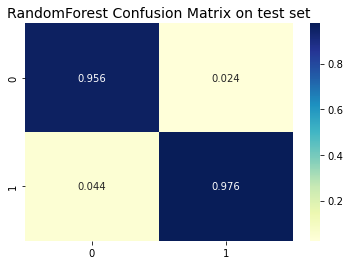

RandomForest best hyperparameters: {'criterion': 'entropy', 'max_depth': 90, 'max_features': 0.75, 'min_samples_split': 4, 'n_estimators': 400, 'random_state': 42}


In [42]:
# without least important features

search_space ={
    'n_estimators': [350, 400],
    'max_features': [0.5, 0.75],
    'min_samples_split' : [4, 6],
    'criterion': ['entropy'],
    'max_depth': [90, None],
    'random_state': [42]
}

best_randomforest(X_train_least, X_test_least, y_train_least, y_test_least, search_space)

### 4.5.2. With every feature

In [49]:
# every feature

X_train_all, X_test_all, y_train_all, y_test_all = randomforest_helper_attributes(X)

RandomForest Overall accuracy on test set: 0.9645
RandomForest best hyperparameters: {'random_state': 42, 'n_estimators': 400, 'min_samples_split': 6, 'max_features': 0.5, 'max_depth': 70, 'criterion': 'log_loss'}


RandomForest Overall accuracy on test set: 0.9647


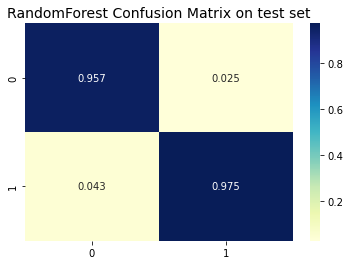

RandomForest best hyperparameters: {'criterion': 'log_loss', 'max_depth': 50, 'max_features': 0.75, 'min_samples_split': 6, 'n_estimators': 350, 'random_state': 42}


In [50]:
# every feature

search_space ={
    'n_estimators': [350, 400],
    'max_features': [0.75, None],
    'min_samples_split' : [4,6],
    'criterion': ['log_loss', 'entropy'],
    'max_depth': [50, 60, 70],
    'random_state': [42]
}

best_randomforest(X_train_all, X_test_all, y_train_all, y_test_all, search_space)

### 4.5.3. Final model
After some analysis and hyperparameter tuning, we discover that the best model is *RandomForest*, with the following hyperparameters (the other values are set the default ones):

- *n_estimators*: 350 
- *min_samples_split*: 6
- *max_features*: 0.75
- *max_depth*: 50
- *criterion*: log_loss

Regarding the dataframe, the best choice is to use the whole dataset, without removing any feature. Together, this combinations returns an accuracy of 96,47% on the validation set.
# 5. conclusions
We have been provided with a dataset containing responses to a satisfaction survey of airline customers. The goal was to gain insight about into the data and build an algorithm that can predict passenger satisfaction. During our analysis, we saw that **arrival and departure delay** were highly correlated, but were presenting some null values, so we combined this information together to manage them. Moreover, we saw that the airline usually arrives on time and that such delay seem not to be that important to satisfaction.<br>
In fact, when comparing the model we got with every feature, there was only a 0.03 percentage point difference with the model without the least important feature, among which there was **delay in minutes** (the variable containing data from arrival and departure delay).<br>
Furthermore, we discoverder that, while there were some outliers withing the dataframe, eliminating them decreased the performance of the algorithm. This is probably because this information helped the model to understand what to do when such data emerged.<br>
In the end, we built a *RandomForest* algorithm that tags instances correclty 96,47% of the time.